# Info 3950 Problem Set 6

**due Thu evening 20 Apr 2023 23:00**

Submit via [gradescope](https://gradescope.com/).

<font size="-1">[Note that these problem sets are not intended as group projects: the work you submit must be your own. You can discuss with other students at a high level, for example general methods or strategies to solve a problem, but you must cite the other student(s) in your submission. Any work you submit must be your own understanding of the solution, the details of which you personally and individually worked out, and written in your own words. In no cases should notebooks or code be shared. It is also good practice to attribute any other sources you've used.]</font>

# 0) Name and netid (will be graded)

**A.** Put your name and netid in the cell below (a suprising number of students did not succeed to do that for ps5):

**B.** Check that your name and netid are correct in the cell above

In [2]:
import numpy as np, matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import nltk
from nltk.corpus import gutenberg
from nltk.corpus import shakespeare


from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, cross_validate, KFold
from collections import Counter
from urllib.request import urlopen
from sklearn.svm import SVC # "Support vector classifier"
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

import glob
import re

## 1) Stylometrics with stopwords

Many noticed that in **1.D.ii** of ps5, three of the training points were misclassified by the k-means classifier trained on the top 9 principal components of the 60 most common stopwords.

**A.** i) Train an SVM classifier for this problem, using default values of the `SVC()` parameters, on the 77 training points with the features PCA-reduced to just 2 dimensions. Then test on the 122 test points (similarly PCA-reduced). What are the training and test scores?

ii) Make a two dimensional plot showing the decision boundaries, as in the first plot of [plot_rbf_parameters.html](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html) (or use the more visible colors in [lec20_rbfparams.ipynb](https://courses.cit.cornell.edu/info3950_2023sp/lec20_rbfparams.ipynb)). Determine best values of C,gamma for this problem by looking at cluster boundaries for intuition. (This may require some trial-and-error experimentation.) What are the training and test scores for those best values?

In [39]:
# training data

shf = [fileid for fileid in gutenberg.fileids() if fileid.startswith('shakespeare')]

#now try four authors
shw = [w.lower() for fileid in shf for w in gutenberg.words(fileid) if w[0].isalpha()]
mpw = [w.lower() for w in gutenberg.words('milton-paradise.txt') if w[0].isalpha()]
auw = [w.lower() for w in gutenberg.words('austen-persuasion.txt') if w[0].isalpha()]
mdw_all = [w.lower() for w in gutenberg.words('melville-moby_dick.txt') if w[0].isalpha()]
mdw = mdw_all[:80000] #truncate moby dick words to 16 5k pieces
# len(shw),len(mpw),len(auw),len(mdw) #numbers of words


chimneys_url = 'https://www.gutenberg.org/cache/epub/65238/pg65238.txt'
chimneys = urlopen(chimneys_url).read().decode('utf-8')
agw = [w.lower() for w in nltk.word_tokenize(chimneys[897:439351]) if w[0].isalpha()]

fdist=Counter(shw + mpw + auw + mdw + agw) #for all five
top60,_=zip(*fdist.most_common(60)) #now use top 60 from combined
print (top60)

M5=[]
for corp in [shw,mpw,auw,mdw,agw]:
#   print(len(corp)//5000)
  for i in range(0,len(corp)-4999,5000):  # 13 blocks of shakespeare, 16 of milton, austen,moby, christie
    fdist = Counter(corp[i:i+5000])
    M5.append([fdist[w] for w in top60])
M5 = np.array(M5).astype(np.float64)
print(M5.shape)

#center the data on zero, and normalize standard deviation
scaler5 = preprocessing.StandardScaler()
M5_scaled = scaler5.fit_transform(M5)

pca = PCA(2)
X_train = pca.fit_transform(M5_scaled)
y_train = list(13*[0] + 16*[1] + 16*[2] + 16*[3] + 15*[4])

('the', 'and', 'to', 'of', 'a', 'in', 'i', 'that', 'he', 'his', 'it', 'with', 'you', 'was', 'not', 'but', 'as', 'for', 'be', 'all', 'is', 's', 'had', 'him', 'her', 'on', 'this', 'at', 'my', 'so', 'by', 'from', 'she', 'what', 'me', 'or', 'they', 'have', 'no', 'their', 'there', 'which', 'said', 'one', 'now', 'we', 'will', 'were', 'then', 'your', 'more', 'them', 'if', 'who', 'when', 'been', 'do', 'would', 'are', 'd')
(76, 60)


In [40]:
# testing data

mpr_text = urlopen('https://www.gutenberg.org/cache/epub/58/pg58.txt').read().decode('utf-8')

#find beginning and end to strip off gutenberg stuff
mpr_text.index('\r\n'*5 + 'Paradise Regained'), mpr_text.index(5*'\r\n' + '*** END OF THE PROJECT GUTENBERG')

mpr_words = nltk.word_tokenize(mpr_text[767:93590])

T=[]
more_shwords=[]
for fileid in shakespeare.fileids():
    if fileid in ('hamlet.xml', 'j_caesar.xml', 'macbeth.xml'): continue  #already in training data
    more_shwords += shakespeare.words(fileid)
more_shwords = [w.lower() for w in more_shwords if w[0].isalpha()]

mpr = [w.lower() for w in mpr_words if w[0].isalpha()]

aue= [w.lower() for w in gutenberg.words('austen-emma.txt') if w[0].isalpha()]
aus= [w.lower() for w in gutenberg.words('austen-sense.txt') if w[0].isalpha()]


links_url = 'https://www.gutenberg.org/cache/epub/58866/pg58866.txt'
links = urlopen(links_url).read().decode('utf-8')
links_words = [w.lower() for w in nltk.word_tokenize(links[829:373271]) if w[0].isalpha()]


T5=[]
for i in range(0,len(more_shwords)-4999,5000):  # 13 blocks of shakespeare, 16 of milton, austen,moby
    fdist = Counter(more_shwords[i:i+5000])
    T5.append([fdist[w] for w in top60])
for i in range(0,len(mpr)-4999,5000):  # milton paradise regained
    fdist = Counter(mpr[i:i+5000])
    T5.append([fdist[w] for w in top60])
for i in range(0,len(aus+aue)-4999,5000): #austen
    fdist = Counter((aus+aue)[i:i+5000])
    T5.append([fdist[w] for w in top60])
for i in range(0,len(mdw_all[80000:])-4999,5000):  #rest of melville
    fdist = Counter(mdw_all[i+80000:i+85000])
    T5.append([fdist[w] for w in top60])
for i in range(0,len(links_words)-4999,5000):  # milton paradise regained
    fdist = Counter(links_words[i:i+5000])
    T5.append([fdist[w] for w in top60])
len(T5)

X_test = pca.transform(scaler5.transform(T5))
y_test = list(24*[0] + 3*[1] + 56*[2] + 27*[3] + 12*[4])

In [41]:
# 1Ai)

# training
model = SVC()
model.fit(X_train, y_train)

# testing

print(f'Training Score: {model.score(X_train, y_train)*100:.2f}%, or {model.score(X_train, y_train)*122:.0f}/122',
      f' Testing Score: {model.score(X_test, y_test)*100:.2f}%,  or {model.score(X_test, y_test)*122:.0f}/122',
     sep='\n')

Training Score: 100.00%, or 122/122
 Testing Score: 86.07%,  or 105/122


ii) Make a two dimensional plot showing the decision boundaries, as in the first plot of [plot_rbf_parameters.html](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html) (or use the more visible colors in [lec20_rbfparams.ipynb](https://courses.cit.cornell.edu/info3950_2023sp/lec20_rbfparams.ipynb)). Determine best values of C,gamma for this problem by looking at cluster boundaries for intuition. (This may require some trial-and-error experimentation.) What are the training and test scores for those best values?

In [42]:
# 1Aii)

# from lec20 rbfparams

# looping through values for C and gamma
C_2d_range = [.01, 1, 100]
gamma_2d_range = [.1, 1, 10]
classifiers = []
for C in C_2d_range:
    for gamma in gamma_2d_range:
        clf = SVC(C=C, gamma=gamma)
        clf.fit(X_train, y_train)
        classifiers.append((C, gamma, clf))
        
        

clrs = list(13*'b' + 16*'g' + 16*'r' + 16*'y')
testclrs = list(24*'b' + 3*'g' + 56*'r' + 27*'y') + ['C6']*12

In [43]:
C_range = np.logspace(-2, 10, 20)
gamma_range = np.logspace(-9, 3, 20)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_train, y_train)

print(
    "The best parameters are %s:\n\tTraining score: %0.2f\n\tTesting score: %.2f"
    % (grid.best_params_, grid.best_score_*100,grid.score(X_test,y_test)*100)
)

best_C, best_gamma = grid.best_params_.values()

scores = grid.cv_results_["mean_test_score"].reshape(len(C_range), len(gamma_range))

The best parameters are {'C': 0.18329807108324356, 'gamma': 0.03792690190732246}:
	Training score: 100.00
	Testing score: 82.79


In [44]:
from matplotlib.colors import LinearSegmentedColormap
cwlist = [plt.cm.coolwarm(0.),  plt.cm.coolwarm(.25), (1,1,1,1),
                       plt.cm.coolwarm(.75), plt.cm.coolwarm(1.)]
my_coolwarm = LinearSegmentedColormap.from_list('cw', cwlist)

In [45]:
plt.figure(figsize=(8, 6))
xx, yy = np.meshgrid(np.linspace(-3, 3, 500), np.linspace(-3, 3, 500))
for k, (C, gamma, clf) in enumerate(classifiers):
    # evaluate decision function in a grid
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # visualize decision function for these parameters
    plt.subplot(len(C_2d_range), len(gamma_2d_range), k + 1)
    if k < len(gamma_2d_range): plt.title(f'gamma={gamma}')
    if k%len(gamma_2d_range) == 0: plt.ylabel(f'C={C}' +' '*12, rotation=0, fontsize=12)

    # visualize parameter's effect on decision function
    plt.pcolormesh(xx, yy, -Z, cmap=my_coolwarm)
    plt.scatter(*X_2d.T, c=np.array(['r','b'])[y_2d], edgecolors="gray")
    plt.xticks(())
    plt.yticks(())
    plt.axis("tight")

ValueError: cannot reshape array of size 1250000 into shape (500,500)

<Figure size 800x600 with 0 Axes>

**B.** Again for those best C,gamma values in part A, what are the training and test scores on the same training and test data, but using PCA reduction down to 3, 9 (as in ps5), and the full 60 dimensionsional data?

In [ ]:
for n_components in [3,9,60]:
    pca = PCA(n_components)
    
    # train data
    X_train = pca.fit_transform(M5_scaled)

    # test data
    X_test = pca.transform(scaler5.transform(T5))
    
    # training
    model = SVC(C=best_C, gamma=best_gamma)
    model.fit(X_train, y_train)

    # testing
    print(f'{n_components}-dimensional data:',
          f'Training Score: {model.score(X_train, y_train)*100:.2f}%, or {model.score(X_train, y_train)*122:.0f}/122',
          f'Testing Score:  {model.score(X_test,  y_test) *100:.2f}%, or {model.score(X_test, y_test)*122:.0f}/122\n',
         sep='\n')


In [ ]:
print(grid.best_params_,"""

3-dimensional data:
Training Score: 100.00%, or 122/122
Testing Score:  100.00%, or 122/122

9-dimensional data:
Training Score: 100.00%, or 122/122
Testing Score:  99.18%, or 121/122

60-dimensional data:
Training Score: 80.26%, or 98/122
Testing Score:  69.67%, or 85/122
""")

## 2) Stylometrics with letter 3-grams

Data: download and unpack the file [ps6data.tar.gz](https://courses.cit.cornell.edu/info3950_2023sp/ps6data.tar.gz) (or equivalently [ps6data.zip](https://courses.cit.cornell.edu/info3950_2023sp/ps6data.zip)).
It has a file auths.txt giving the names of the 20 NYTimes columnists used in the data, and subdirectories train/ and test/:<br>
The train/ subdirectory in turn has 20 subdirectories, labelled by author initials, each of which contains 32 text files by that author. Those are the training and validation files. The test/ subdirectory also has 20 subdirectories, each of which contains 10 additional text files by that author.

You should calculate the letter 3-gram features for each item as in [lec18_l3g_sty.ipynb](https://nbviewer.org/url/courses.cit.cornell.edu/info3950_2023sp/lec18_l3g_sty.ipynb), with **one modification**.

---
*Calculate the most common features to use as usual, by counting the total number of occurrences in the training set.
But when using those to calculate the features for each individual item, **divide the number counts by the length of the text** (since the texts are of varying lengths, this will prevent the properties of longer texts from dominating).*

**A.** i) Start with the most common 1500 features as in [lec18_l3g_sty.ipynb](https://nbviewer.org/url/courses.cit.cornell.edu/info3950_2023sp/lec18_l3g_sty.ipynb). On the training set (the 32 items for each of 20 authors), use cv=8 cross validation (which will result in 32/8 = 4 items in each test split for each author) to find the best values of the parameters C and gamma, using GridSearchCV as in lec18_l3g_sty.ipynb.

ii) Plot the training and test scores for the 8 splits using those best values of C and gamma, and indicate the average test and training scores.

iii) Plot a confusion matrix for the full `32*20 = 640` test items. Which authors are the most confused?

In [24]:
auth_dirs = sorted([path.replace('ps6data/train/', '') for path in glob.glob(f"ps6data/train/*")])

train_fileids = np.array([glob.glob(f"ps6data/train/{auth}/**") for auth in auth_dirs]).flatten()
test_fileids = np.array([glob.glob(f"ps6data/test/{auth}/**") for auth in auth_dirs]).flatten()

y_train = np.array([[i]*32 for i in range(len(auth_dirs))]).flatten()
y_test = np.array([[i]*10 for i in range(len(auth_dirs))]).flatten()

In [25]:
train_fileids[0]

'ps6data/train/bs/covid-health-misinformation.txt'

In [26]:
N = 1500
allcounts = Counter()
for f in train_fileids:
    txt = re.sub('\s+',' ', open(f).read().lower())

    counter = Counter([txt[i:i+3] for i in range(len(txt))])
    allcounts += Counter(counter)
top1500 = dict(allcounts.most_common(N)).keys()

In [27]:
top1500

dict_keys([' th', 'the', 'he ', 'ing', ' an', ' to', ' in', 'ng ', ' of', 'nd ', 'and', 'to ', 'ed ', 'of ', 'at ', ' a ', 'in ', 'ion', ' co', 'er ', 'on ', 'hat', 're ', 'tha', 'is ', 'ent', ' re', 's a', 'e t', 'es ', 'tio', 'as ', ' be', ' wh', 'an ', 'e a', 't t', 'or ', 's t', 'd t', ' ha', 'n t', 'for', 'ly ', 'al ', ' fo', 'ati', 'en ', 'ate', 'st ', ' is', ' pr', 'her', 'ut ', 'e s', ' on', ' it', ' ma', 've ', ' de', 'ter', ' st', ' wi', 's, ', 'e o', 'nt ', 'ts ', "'s ", ' wa', 'ver', 'n a', 'res', 'ica', 'ers', ' no', 'e w', 's o', 'e c', ' ca', 'all', 'e i', ' he', 'le ', 'se ', ' mo', 'con', ' we', 'e p', 'ere', 't a', ' as', ', a', ' po', 'th ', ' so', 'thi', 'are', 's. ', 'his', 'f t', 'll ', ' ar', 'ess', ' wo', 'ons', 'ld ', 'ide', ' se', 'ive', 'ted', 'can', 'it ', 'te ', 't i', 's i', 'e, ', ', t', 'eve', ' pa', 'g t', 'd a', 'rea', ' li', 'pro', ' pe', ' bu', 'out', 'ith', 'rs ', ' al', 't o', 'sta', 'ns ', 'r t', 'wit', '. t', 's w', 'ill', 'nce', 'me ', ' tr', 'e

In [28]:
# training x_data
M = []
for f in train_fileids:
    txt = re.sub('\s+',' ', open(f).read().lower())
    c = Counter([txt[i:i+3] for i in range(len(txt))])
    c = Counter({key: value/len(txt) for key, value in c.items()})
    M.append([c[g3] for g3 in top1500])

M = np.array(M)
M.shape

# testing x_data
T = []

for f in test_fileids:
    txt = re.sub('\s+',' ', open(f).read().lower())
    c = Counter([txt[i:i+3] for i in range(len(txt))])
    c = Counter({key: value/len(txt) for key, value in c.items()})
    T.append([c[g3] for g3 in top1500])

T = np.array(T)
T.shape

(200, 1500)

In [29]:
y_test.shape

(200,)

In [30]:
%%time

C_range = np.logspace(-2, 10, 20)
gamma_range = np.logspace(-9, 3, 20)
param_grid = dict(gamma=gamma_range, C=C_range)
grid = GridSearchCV(SVC(kernel='rbf'),
                   param_grid, cv=8, return_train_score=True).fit(M, y_train)

print(
    "The best parameters are %s:\n\tTraining score: %0.2f\n\tTesting score:  %.2f"
    % (grid.best_params_, grid.best_score_*100,grid.score(T,y_test)*100)
)

best_C, best_gamma = grid.best_params_.values()

The best parameters are {'C': 14.38449888287663, 'gamma': 233.57214690901213}:
	Training score: 88.12
	Testing score:  81.50
CPU times: user 19min 47s, sys: 5.52 s, total: 19min 52s
Wall time: 19min 53s


ii) Plot the training and test scores for the 8 splits using those best values of C and gamma, and indicate the average test and training scores.

In [31]:
train_scores = [grid.cv_results_[f'split{i}_train_score'][grid.best_index_] for i in range(8)]
test_scores = [grid.cv_results_[f'split{i}_test_score'][grid.best_index_] for i in range(8)]

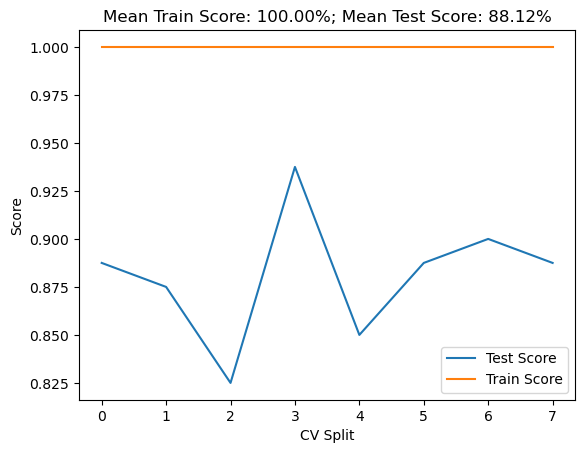

In [32]:
plt.plot(test_scores, label='Test Score')
plt.plot(train_scores, label='Train Score')

title = 'Mean Train Score: {:.2f}%; Mean Test Score: {:.2f}%'.format(np.mean(train_scores)*100,np.mean(test_scores)*100)
plt.title(title)
plt.xlabel('CV Split')
plt.ylabel('Score')
plt.legend()
plt.show();


iii) Plot a confusion matrix for the full 32*20 = 640 test items. Which authors are the most confused?

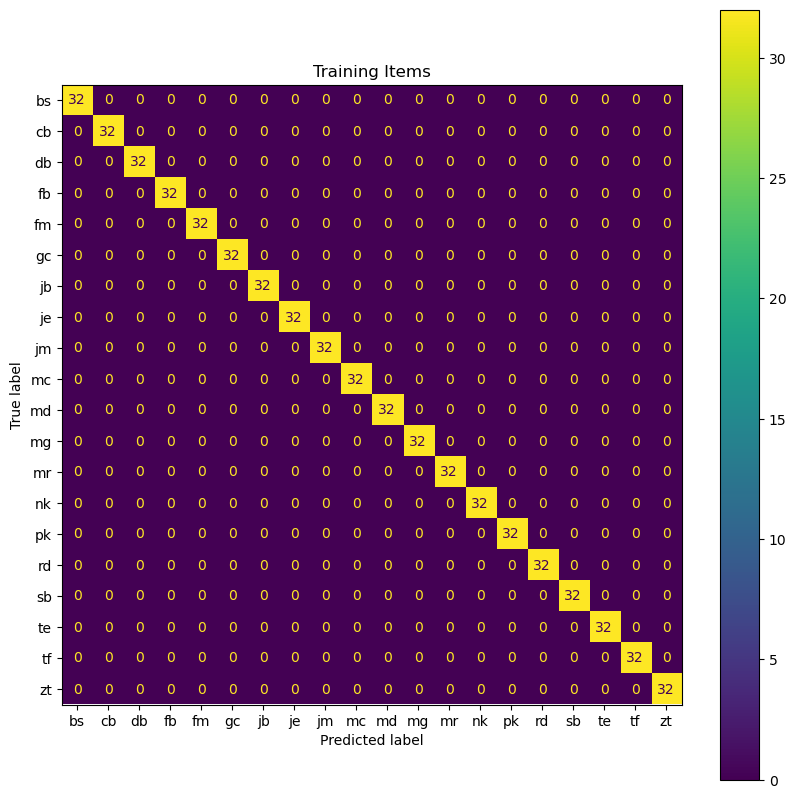

In [34]:
fig, ax = plt.subplots(figsize=(10, 10))

ConfusionMatrixDisplay.from_estimator(grid,M,y_train,
                    display_labels=auth_dirs, ax=ax)

plt.title('Training Items')
plt.show()

No authors are confused using the optimal parameters found

**B.**  i) Now determine the accuracy score on the test data (the additional 10 items for each of the 20 authors), and draw a contingency matrix for performance on the test data for the 20 authors.

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

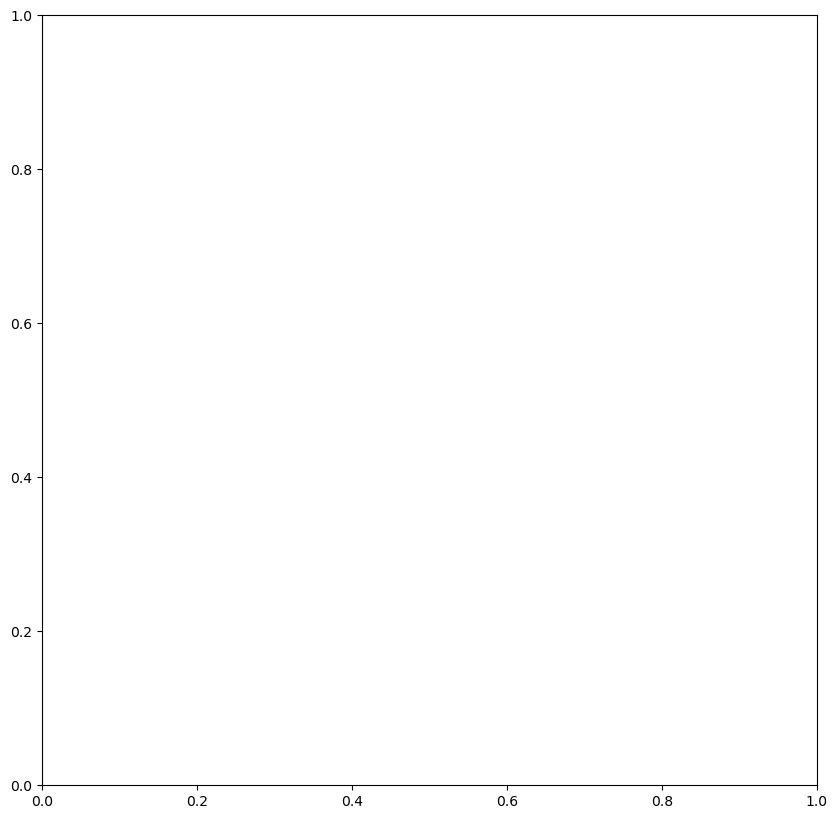

In [47]:
fig, ax = plt.subplots(figsize=(10, 10))

ConfusionMatrixDisplay.from_estimator(grid,T,y_test,
                    display_labels=auth_dirs, ax=ax)

plt.title(f'Test Items | Test Accuracy Score: {grid.score(T,y_test)*100:.2f}')
plt.show()

In [48]:
print('''Authors most confused:
cb (8 incorrect)
mg (5 incorrect)
bs (4 incorrect)
''')

Authors most confused:
cb (8 incorrect)
mg (5 incorrect)
bs (4 incorrect)



ii) Plot the training and test scores as a function of the number of features, as in [lec18_l3g_sty.ipynb](https://nbviewer.org/url/courses.cit.cornell.edu/info3950_2023sp/lec18_l3g_sty.ipynb), from 1 to 2000 features (or more), using the optimal C,gamma from part A. 

In [52]:
X_data = np.concatenate([M,T])
y_data = np.concatenate([y_train,y_test])

clf = SVC(C=grid.best_params_['C'],gamma=grid.best_params_['gamma'],kernel='rbf')
nfs = [1,10,25,50,75,100,250,500,750,1000,1500,2000] # + list(range(1000,5100,500))
test_means = []
train_means = []
for Nf in nfs:
    cv10 = cross_validate(clf, X_data[:,:Nf], y_data, cv=5, return_train_score=True)
    test_means.append(cv10['test_score'].mean())
    train_means.append(cv10['train_score'].mean())

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [53]:
test_means, train_means

NameError: name 'test_means' is not defined